<a href="https://colab.research.google.com/github/tumbler-lab/AutoEncoder/blob/main/ConvolutionalAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.ToTensor() # tensor

train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
num_workers = 4
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Definition

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ConvAutoEncoder(nn.Module):
    def __init__(self, z_dim):
        super(ConvAutoEncoder, self).__init__()
        ## encoder Layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # poolした場所おぼえる
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True)
        self.linear1 = nn.Linear(7*7*32, z_dim)

        ## decoder Layer
        # convtransposeはconvの逆
        self.t_conv1 =  nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.t_conv2 =  nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1)
        
        self.unpool1 = nn.MaxUnpool2d(2, 2)
        self.unpool2 = nn.MaxUnpool2d(2, 2)
        self.tlinear1 = nn.Linear(z_dim, 7*7*32)

    
    def encode(self, x):
        ## encode
        x = F.relu(self.conv1(x))
        x, a = self.pool1(x)
        x = F.relu(self.conv2(x))
        x, b = self.pool2(x)
        x = x.view(-1, 7*7*32)
        x = self.linear1(x)
        return x, a, b

    def decode(self, x, a, b):
        ## decode
        x = F.relu(self.tlinear1(F.relu(x)))
        x = x.view(-1, 32, 7, 7)
        x = self.unpool1(x, b)
        x = F.relu(self.t_conv1(x))
        x = self.unpool2(x, a)
        x = torch.sigmoid(self.t_conv2(x))
        return x


    def forward(self, x):
        z, a, b = self.encode(x)
        x = self.decode(z, a, b)
        
        return x, z


# Training

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ConvAutoEncoder(2).to(device)
print(model)
# loss function
criterion = nn.MSELoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30

ConvAutoEncoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=1568, out_features=2, bias=True)
  (t_conv1): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (unpool1): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (unpool2): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (tlinear1): Linear(in_features=2, out_features=1568, bias=True)
)


In [ ]:
list_z = [] # zのリスト
list_label = [] # label list
for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for data in train_loader:
        optimizer.zero_grad() # 重み初期化
        
        images, label = data
        images = images.to(device)
        outputs, z = model(images)
        list_z.append(z)
        list_label.append(label)
        loss = criterion(outputs, images) # 生成した画像と元の画像の差異

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1 	Training Loss: 0.030439
Epoch: 2 	Training Loss: 0.008855
Epoch: 3 	Training Loss: 0.007425
Epoch: 4 	Training Loss: 0.006792
Epoch: 5 	Training Loss: 0.006523
Epoch: 6 	Training Loss: 0.006377
Epoch: 7 	Training Loss: 0.006284
Epoch: 8 	Training Loss: 0.006216
Epoch: 9 	Training Loss: 0.006162
Epoch: 10 	Training Loss: 0.006113
Epoch: 11 	Training Loss: 0.006069
Epoch: 12 	Training Loss: 0.006032
Epoch: 13 	Training Loss: 0.006000
Epoch: 14 	Training Loss: 0.005973
Epoch: 15 	Training Loss: 0.005949
Epoch: 16 	Training Loss: 0.005928
Epoch: 17 	Training Loss: 0.005911
Epoch: 18 	Training Loss: 0.005895
Epoch: 19 	Training Loss: 0.005882
Epoch: 20 	Training Loss: 0.005869
Epoch: 21 	Training Loss: 0.005858
Epoch: 22 	Training Loss: 0.005847
Epoch: 23 	Training Loss: 0.005838
Epoch: 24 	Training Loss: 0.005829
Epoch: 25 	Training Loss: 0.005821
Epoch: 26 	Training Loss: 0.005813
Epoch: 27 	Training Loss: 0.005807
Epoch: 28 	Training Loss: 0.005800
Epoch: 29 	Training Loss: 0.0

In [ ]:
list_z_test = [] # zのリスト
list_label_test = [] # label list
model.eval()
for data in test_loader:
    images, label = data
    images = images.to(device)
    outputs, z = model(images)
    list_z_test.append(z)
    list_label_test.append(label)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
array_z_test = np.concatenate([z.cpu().detach().numpy().copy() for z in list_z_test])
display(array_z_test)
array_label_test = np.concatenate([z.cpu().detach().numpy().copy() for z in list_label_test])
display(array_label_test)

array([[-0.5495486 , -0.37918085],
       [-0.6048273 , -0.44697952],
       [-0.5077963 , -0.27359733],
       ...,
       [-0.67937976, -0.37940755],
       [-0.57673043, -0.37461296],
       [-0.6716093 , -0.4760433 ]], dtype=float32)

array([7, 2, 1, ..., 4, 5, 6])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


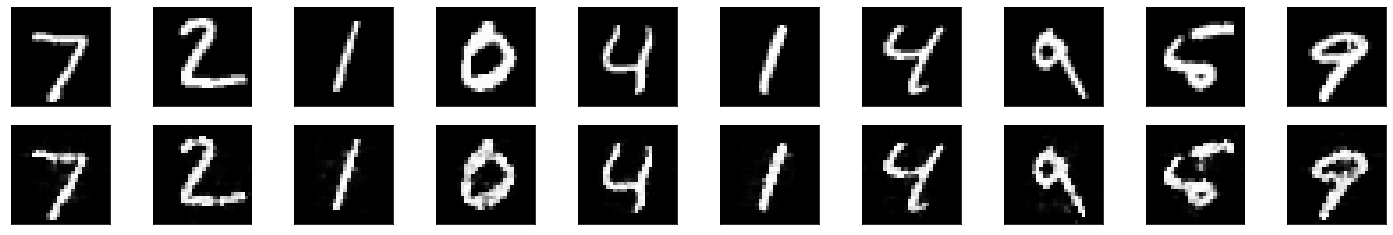

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.to(device)

output, _ = model(images)
images = images.view(batch_size, 1, 28, 28)
images = images.cpu().numpy()


output = output.view(batch_size, 1, 28, 28)
output = output.detach().cpu().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25, 4))

for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


# 2次元プロット

In [ ]:
def get_mean(z_mu, y_sample, num):
    for i in range(10):
        idx = y_sample==num
    return np.mean(z_mu[idx], axis=0)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


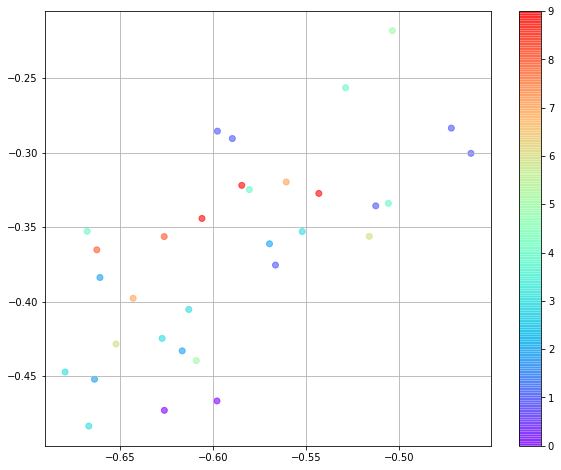

In [ ]:
import matplotlib.pyplot as plt

dataiter =iter(train_loader)
image_sample, label_sample = dataiter.next()
image_sample = image_sample.to(device)
z_mu, a, b = model.encode(image_sample)
z_mu = z_mu.view(32,-1).detach().cpu().numpy().copy()

plt.figure(figsize=(10, 8)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=label_sample, cmap="rainbow", alpha=0.6)
# for i in range(10):
#     m = get_mean(z_mu, label_sample, i)
#     plt.text(m[0], m[1], "{}".format(i), fontsize=20)

plt.colorbar()
plt.grid()

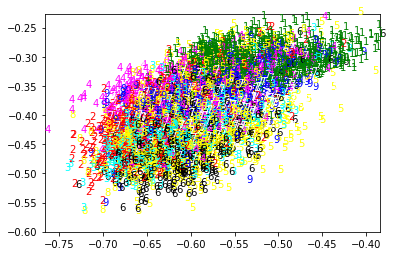

In [ ]:
import matplotlib.pyplot as plt

# dataiter =iter(train_loader)
# image_sample, label_sample = dataiter.next()
# image_sample = image_sample.to(device)
# z_mu, a, b = model.encode(image_sample)
# z_mu = z_mu.view(32,-1).detach().cpu().numpy().copy()
z_mu = array_z_test.copy()
# z_mu[:, 1] = 1

idx1, idx2 = 0, 1
plt.xlim(z_mu[:, idx1].min(), z_mu[:, idx1].max())
plt.ylim(z_mu[:, idx2].min(), z_mu[:, idx2].max())
color_dict = {0: 'blue', 1: 'green', 2: 'red', 3: 'cyan',
              4: 'magenta', 5: 'yellow', 6: 'black', 7: 'white', 8: 'yellow', 9: 'blue'}
for z, label in zip(z_mu, array_label_test):
    if label:
        plt.text(z[idx1], z[idx2], s=label.item(), color=color_dict[label.item()])
plt.show()

In [ ]:
z_mu

array([[-0.5495486 , -0.37918085],
       [-0.6048273 , -0.44697952],
       [-0.5077963 , -0.27359733],
       ...,
       [-0.67937976, -0.37940755],
       [-0.57673043, -0.37461296],
       [-0.6716093 , -0.4760433 ]], dtype=float32)